- https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/agent_supervisor.ipynb

In [1]:
from IPython.display import Image

In [2]:
Image(url='https://raw.githubusercontent.com/langchain-ai/langgraph/f3b5d804ab72a1e7485dbc172ea73957efb268c1/examples/multi_agent/img/supervisor-diagram.png', width=500)

- multi agents
    - as a team/group
- 三条边指向 supervisor
    - `{agent1, agent2, agent3} => supervisor`
    ```
    for agent in ['agent 1', 'agent 2', 'agent 3']:
        # We want our workers to ALWAYS "report back" to the supervisor when done
        workflow.add_edge(agent, "supervisor")
    ```
- share state
    - global state of the graph
- message type
    - langchain_core.messages.ai.AIMessage,
    - langchain_core.messages.human.HumanMessage,
    - langchain_core.messages.chat.ChatMessage,
    - langchain_core.messages.system.SystemMessage,
    - langchain_core.messages.function.FunctionMessage,
    - langchain_core.messages.tool.ToolMessage

In [5]:
from dotenv import load_dotenv
assert load_dotenv()

In [12]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain_core.messages import HumanMessage

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

### tools

In [9]:
tavily_tool = TavilySearchResults(max_results=5)
# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

### helper utilities

In [11]:
# convert the agent response to a human message
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

### agent supervisor (node of the graph)

In [14]:
members = ["Researcher", "Coder"]
#  variables: members
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

In [16]:
str(options)

"['FINISH', 'Researcher', 'Coder']"

In [15]:
class RouteResponse(BaseModel):
    next: Literal[*options]

In [17]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

In [18]:
prompt.pretty_print()

================================ System Message ================================

You are a supervisor tasked with managing a conversation between the following workers:  {members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.

============================= Messages Placeholder =============================

{messages}

================================ System Message ================================

Given the conversation above, who should act next? Or should we FINISH? Select one of: {options}


In [20]:
prompt

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, partial_variables={'options': "['FINISH', 'Researcher', 'Coder']", 'members': 'Researcher, Coder'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['members'], template='You are a supervisor tasked with managing a conversation between the following workers:  {members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH.')), MessagesPlaceholder(variable_name='messages'), SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['options'], template='Given the conve

In [21]:
llm = ChatOpenAI(model="gpt-4o")

In [23]:
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(RouteResponse)
    )
    return supervisor_chain.invoke(state)

### nodes & graph

In [24]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

In [25]:
# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

In [26]:
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [27]:
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

In [28]:
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [29]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")

In [30]:
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

In [33]:
conditional_map

{'Researcher': 'Researcher', 'Coder': 'Coder', 'FINISH': '__end__'}

In [31]:
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

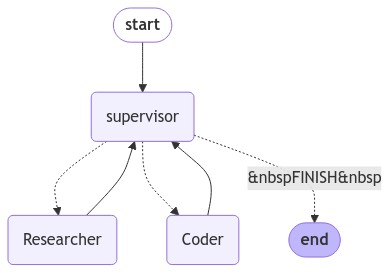

In [32]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Invoke the team

In [34]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    # if "__end__" not in s:
    print(s)
    print("----")

{'supervisor': {'next': 'Coder'}}
----


Python REPL can execute arbitrary code. Use with caution.


{'Coder': {'messages': [HumanMessage(content='The code executed successfully and printed the following output to the terminal:\n\n```\nHello, World!\n```', name='Coder')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [36]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Write a brief research report on pikas.")]},
    {"recursion_limit": 10},
):
    # if "__end__" not in s:
    print(s)
    print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Research Report on Pikas\n\n#### Introduction\nPikas are small, mountain-dwelling mammals of the family Ochotonidae, closely related to rabbits and hares. These creatures are known for their distinctive high-pitched calls and their adaptation to cold, alpine environments. They are primarily found in North America and Asia.\n\n#### Habitat and Behavior\nPikas typically inhabit rocky slopes and talus fields in mountainous regions, where they can find crevices for shelter and abundant vegetation for food. They are active throughout the year and do not hibernate. Instead, they engage in a behavior known as "haying," where they gather and store dried plant materials in caches to sustain themselves through the winter months.\n\nPikas are highly sensitive to temperature changes and prefer foraging in cooler conditions, generally below 25°C (77°F). With rising temperatures due to climate change, 